# Temporary Notebook for developing new Data prep Process


In [1]:
from collections import defaultdict

import pandas as pd


In [2]:
# Local functions and classes
from types_and_classes import *
from utilities import *
from utilities import points_to_polygon
#from debug_tools import *
from debug_tools import make_sphere
#from structure_slice import *
#from structure_set import *
#from relations import *
from shapely.geometry import Polygon
from types_and_classes import Contour

### Global Settings

In [3]:
PRECISION = 2

In [4]:
%matplotlib inline

## Relationship Tests by Relationship Type

### Color Coding
<table style="border: 2px solid black; width=50px;"><tr><td>
<ul style="font-weight: 900; font-size: 20px;">
<li style="color: blue;">region a</li>
<li style="color: green;">region b</li>
<li style="color: orange;">intersection of a & b</li></ul>
</tr></td></>

## Contains

<link rel="stylesheet" href="relations.css">
<table width="350px">
<tr class="l"><th>Contains</th><th>Transitive</th></tr>
<td class="d" colspan="2">
All points of <span class="b">b</span> lie in the interior of <span class="a">a</span>, no points of <span class="b">b</span> lie in the exterior of <span class="a">a</span>, some points in <span class="a">a</span> are exterior to <span class="b">b</span>, and the boundaries of <span class="a">a</span> and <span class="b">b</span> do not intersect.
</td></tr>
<tr><td colspan="2">
<img src="Images/Relationships/contains simple.png" alt="Contains">
<img src="Images/Relationships/contains with hole.png" alt="Contains With Hole">
</td></tr>
</table></td></tr></table>

### Contains

#### Embedded Spheres
![Embedded Spheres](<Images/FreeCAD Images/Embedded Spheres.png>)

In [5]:
slice_spacing = 0.5
# Body structure defines slices in use
sphere6 = make_sphere(roi_num=1, radius=3, spacing=slice_spacing)
sphere3 = make_sphere(roi_num=2, radius=1.5, spacing=slice_spacing)
# combine the contours
slice_data = sphere6 + sphere3


In [23]:
slice_spacing = 0.5
left_sphere = make_sphere(roi_num=1, radius=2, offset_x=-2.5, offset_z=0,
                          spacing=slice_spacing)
right_sphere = make_sphere(roi_num=1, radius=2, offset_x=2.5, offset_z=0,
                           spacing=slice_spacing)
right_middle_sphere = make_sphere(roi_num=2, radius=1, offset_x=2.5, offset_z=0,
                                  spacing=slice_spacing)
# combine the contours
slice_data = left_sphere + right_sphere + right_middle_sphere


### Convert contour points to polygons and sort them by area


In [24]:
contours = pd.DataFrame(slice_data)
# Convert the contours points to polygons and calculate their areas
contours['Polygon'] = contours['Points'].apply(points_to_polygon)
contours['Area'] = contours['Polygon'].apply(lambda poly: poly.area)
# Sort the contours by ROI, Slice and decreasing Area
# Decreasing area is important because that an earlier contour cannot be inside
# a later one.
contours.sort_values(by=['ROI', 'Slice', 'Area'],
                     ascending=[True, True, False],
                     inplace=True)


In [25]:
slice_sequence = SliceSequence(contours.Slice)

In [26]:
slice_sequence.slices

[-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]

In [27]:
roi = 1
contour_set = contours[contours.ROI == roi]


### Create identify contours that are holes and build a graph of the contours

In [28]:
contour_slice = defaultdict(list)
contour_set.set_index('Slice', inplace=True)
for slice_index, contour in contour_set.Polygon.items():
    contours_on_slice = contour_slice[slice_index]
    new_contour = Contour(roi, slice_index, contour, contours_on_slice)
    contour_slice[slice_index].append(new_contour)


#### Create an graph of the contours for the ROI

In [29]:
# Create an graph of the contours for the ROI
contour_graph = nx.Graph()
label_list = []

# Add nodes to the graph
for contours in contour_slice.values():
    for contour in contours:
        contour_label = contour.index
        contour_graph.add_node(contour_label, contour=contour)
        roi, slice_index, idx = contour_label
        label_list.append({
            'ROI': roi,
            'SliceIndex': slice_index,
            'HoleType': contour.hole_type,
            'ContourIndex': idx,
            'Label': contour_label
            })
contour_lookup = pd.DataFrame(label_list)

In [30]:
contour_lookup.HoleType = contour_lookup.HoleType.fillna('None')
contour_lookup.HoleType = contour_lookup.HoleType.astype('category')
contour_lookup.HoleType.cat.set_categories(['Open', 'Closed', 'Unknown', 'None'])
contour_lookup.sort_values(by=['SliceIndex', 'ContourIndex'],  inplace=True)


**Find Contour Neighbours**

- For each Node in the ROI-specific Contour Graph, *starting with the first SliceIndex*:

1. Use the SliceSequence to obtain the Next SliceIndex.
2. Find all Contour nodes of the same hole type *(IsHole True or IsHole False)* with that Next SliceIndex.
3. If the Hulls of the two polygons overlap:
    > 1. Create an edge between the two Contour nodes
    > 2. Set a contourMatch attribute to the edge with the two Contour nodes as values.
    > 3. Set the Thickness of the edge to the difference between the two SliceIndexes.

4. For each Node in the ROI-specific ContourGraph calculate a Thickness from its edges.

In [31]:
for contour_ref in contour_lookup.itertuples(index=False):
    # Get the contour reference
    this_slice = contour_ref.SliceIndex
    this_label = contour_ref.Label
    hole_type = contour_ref.HoleType
    this_contour = contour_graph.nodes(data=True)[this_label]['contour']
    # Identify the next slice in the sequence
    next_slice = slice_sequence.get_neighbors(this_slice).next_slice
    neighbour_idx = ((contour_lookup.SliceIndex == next_slice) &
                    (contour_lookup.HoleType == hole_type))
    # match this contour to the contours on the next slice
    for neighbour in contour_lookup.loc[neighbour_idx, 'Label']:
        neighbour_contour = contour_graph.nodes(data=True)[neighbour]['contour']
        if this_contour.hull.intersects(neighbour_contour.hull):
            contour_match = ContourMatch(this_contour, neighbour_contour)
            contour_graph.add_edge(this_label, neighbour, match=contour_match)


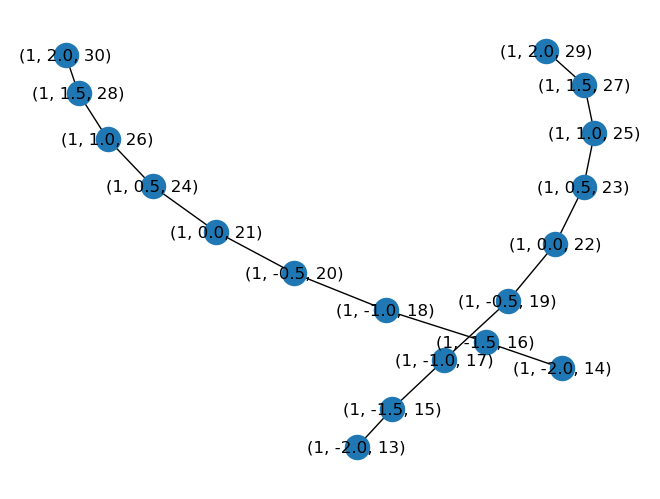

In [32]:
nx.draw(contour_graph, with_labels=True)

**Contour Boundaries**
1. Select all Contour nodes in the ContourGraph with only one edge (degree=1)
2. For each of these nodes:
    1. Generate an interpolated boundary Contour 
        > - The contour is located half way between the boundary contour slice 
            and the neighbour slice that is not linked with an edge.
        > - set IsInterpolated to True
        > - set IsBoundary is True
        > - set IsHole matches the IsHole value of the non-interpolated Contour 
    1. Add the interpolated SliceIndex to SliceSequence:
        > - set 'Original' = False
        > - If the boundary contour SliceIndex  < the interpolated SliceIndex 
            >> - set 'PreviousSlice' = boundary contour SliceIndex, 
            >> - set NextSlice'= None
        > - Else:
            >> - set 'NextSlice'= boundary contour SliceIndex, 
            >> - set 'PreviousSlice '= None
    1. Add the interpolated contour to the contour graph .
    1. Add a ContourMatch edge between the original boundary contour and the interpolated contour.